In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/CelebA_Ppc/0522_070823/checkpoint_4499.ckpt")

Missing logger folder: saved/log/CelebA_Ppc/0523_201146/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0523_201146 exists and is not empty.
Restoring states from the checkpoint path at saved/models/CelebA_Ppc/0522_070823/checkpoint_4499.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0522_070823' to '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0523_201146', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params
------------------------------------------
0 | graph      | CelebAPpc  | 389 K 
1 | predictive | Predictive | 0     
--------------------------------

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                     | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


`Trainer.fit` stopped: `max_epochs=4500` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): CelebAPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): SiLU()
        (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (9): Identity()
        (10): Identity()
      )
    )
  )
  (predictive): Predictive()
)

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [9]:
with model.graph.condition(X=xs) as joint:
    for i in range(299):
        trace, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
        logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
        del trace
        del log_weight
    _, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
del log_weight

Free energy at evaluation 1: 204.781769
Free energy at evaluation 2: -2256.517822
Free energy at evaluation 3: -3824.746094
Free energy at evaluation 4: -4936.000977
Free energy at evaluation 5: -5692.046875
Free energy at evaluation 6: -6248.849121
Free energy at evaluation 7: -6652.472168
Free energy at evaluation 8: -7001.613281
Free energy at evaluation 9: -7282.113281
Free energy at evaluation 10: -7547.770996
Free energy at evaluation 11: -7760.872559
Free energy at evaluation 12: -7961.769531
Free energy at evaluation 13: -8121.376465
Free energy at evaluation 14: -8299.100586
Free energy at evaluation 15: -8429.456055
Free energy at evaluation 16: -8553.013672
Free energy at evaluation 17: -8663.324219
Free energy at evaluation 18: -8788.870117
Free energy at evaluation 19: -8874.431641
Free energy at evaluation 20: -8959.871094
Free energy at evaluation 21: -9028.781250
Free energy at evaluation 22: -9108.250977
Free energy at evaluation 23: -9178.835938
Free energy at evaluat

In [10]:
with model.graph.condition(z=model.graph.nodes['z']['value']) as predictive:
    x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles).mean(dim=0)

In [11]:
import matplotlib.pyplot as plt

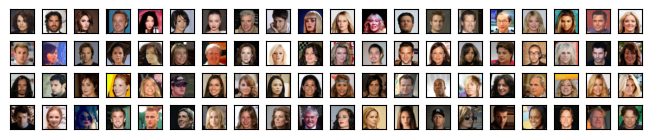

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        orgs = xs[row * 20 + col].detach().transpose(0, -1).cpu()
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_orgs.pdf", bbox_inches="tight")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

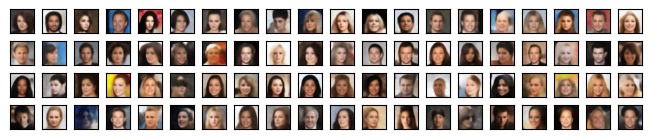

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [14]:
del xs
del x_hats

In [15]:
model.graph.clear()

In [16]:
model.graph(B=80, lr=1e-3, mode="prior", P=model.num_particles)
for _ in range(299):
    model.graph(B=80, lr=1e-3, P=model.num_particles)
x_hats = model.graph(B=80, lr=1e-3, mode="prior", P=model.num_particles)
x_hats = x_hats.mean(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


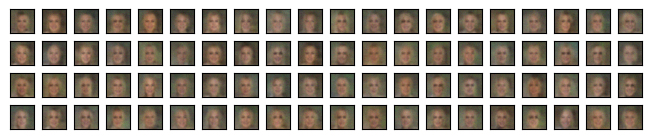

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].squeeze().detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_samples.pdf", bbox_inches="tight")
plt.show()

In [18]:
del x_hats

In [19]:
SEEDS = [123, 456, 789, 101112, 131415]

In [20]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [21]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
            x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)
            with model.graph.condition(X=xs) as predictive:
                trace, _ = predictive(B=len(xs), P=model.num_particles)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 0 under seed 2
Evaluated likelihood for valid batch 1 under seed 2
Evaluated likelihood for valid batch 2 under seed 2
Evaluated likelihood for valid batch 3 under seed 2
Evaluated likelihood for valid batch 0 under seed 3
Evaluated likelihood for valid batch 1 under seed 3
Evaluated likelihood for valid batch 2 under seed 3
Evaluated likelihood for valid batch 3 under seed 3
Evaluated likelihood for valid batch 0 under seed 4
Evaluated likelihood for valid batch 1 under seed 4
Evaluated likelihood for valid batch 2 under seed 4
Evaluated likelihood for valid batch 3 under seed 4


In [22]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-80521.2812), tensor(310.7343))

In [23]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(8.0176e-05), tensor(4.5227e-08))

In [24]:
model.graph.clear()

In [48]:
NUM_SAMPLES = 4096
num_samples = len(glob.glob("data/celeba_ppc/*.jpg"))

In [43]:
import utils.util as util
import glob

In [46]:
util.ensure_dir('data/celeba_ppc')

In [49]:
plt.set_loglevel("error")

while NUM_PREV + num_samples < NUM_SAMPLES:
    x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).mean(dim=0)
    x_hats = x_hats.detach().transpose(1, -1).cpu()
    for k in range(data.batch_size):
        fig = plt.imshow(x_hats[k].squeeze().numpy())
        plt.savefig("data/celeba_ppc/%d.jpg" % (NUM_PREV + num_samples + k))
    num_samples += data.batch_size

    logger.info("Generated %d sample images" % num_samples)

In [25]:
x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).view(data.batch_size * model.num_particles, 3, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

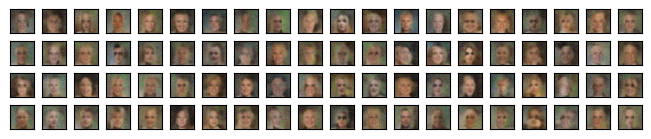

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = x_hats[row * 20 + col].squeeze().detach().transpose(0, -1).cpu()
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.show()